Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Data Reading/Data Understanding

In [2]:
# !apt-get install -y unzip

In [3]:
# !unzip x CNN_assignment.zip

In [4]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2248
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Dataset Creation/Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8226 files belonging to 9 classes.
Using 6581 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8226 files belonging to 9 classes.
Using 1645 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [11]:
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))

32
32


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

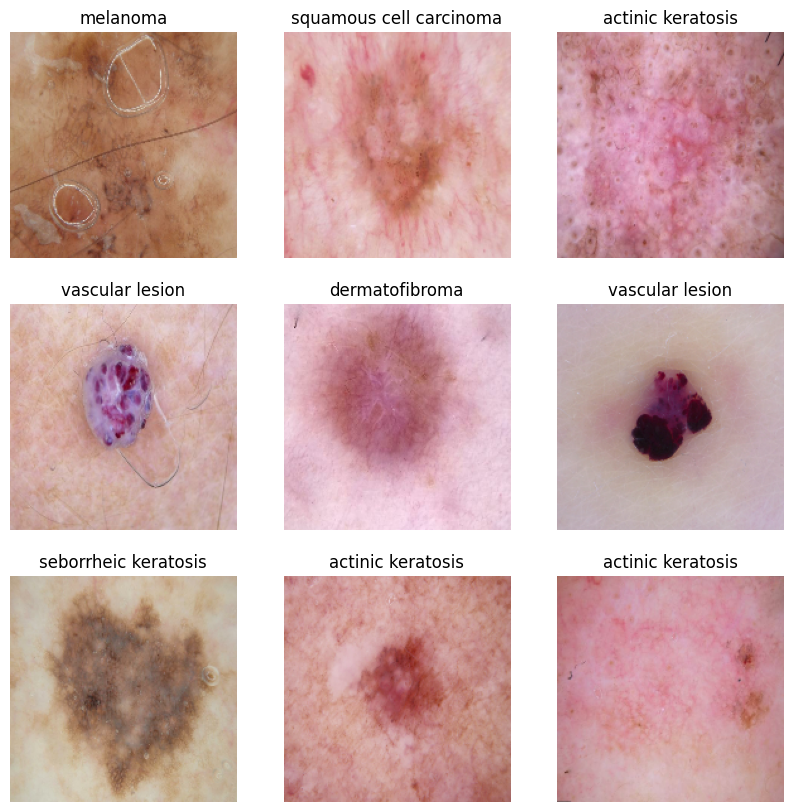

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(5):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### Your code goes here
num_classes = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
  layers.MaxPooling2D(),

  #We slide over the feature map and extract tiles of a specified size.
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.MaxPooling2D(),

  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  ##Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  #fully connected layer
  #A hidden layer in which each node is connected to every node in the subsequent hidden layer.
  #A fully connected layer is also known as a dense layer.

  layers.Dense(128, activation='relu'),

  #Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
  #It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
  #Dense implements the operation: output = activation(dot(input, kernel)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])



### Compile the model
Choose an appropirate optimiser and loss function for model training

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
206/206 [==============================] - 186s 908ms/step - loss: 1.8210 - accuracy: 0.3120 - val_loss: 1.4948 - val_accuracy: 0.4128
Epoch 2/20
206/206 [==============================] - 4s 19ms/step - loss: 1.4264 - accuracy: 0.4738 - val_loss: 1.3406 - val_accuracy: 0.5167
Epoch 3/20
206/206 [==============================] - 4s 19ms/step - loss: 1.2694 - accuracy: 0.5330 - val_loss: 1.2192 - val_accuracy: 0.5489
Epoch 4/20
206/206 [==============================] - 4s 21ms/step - loss: 1.0867 - accuracy: 0.5960 - val_loss: 1.2494 - val_accuracy: 0.5161
Epoch 5/20
206/206 [==============================] - 4s 20ms/step - loss: 0.9642 - accuracy: 0.6464 - val_loss: 1.1586 - val_accuracy: 0.5739
Epoch 6/20
206/206 [==============================] - 4s 19ms/step - loss: 0.8107 - accuracy: 0.7098 - val_loss: 0.9775 - val_accuracy: 0.6571
Epoch 7/20
206/206 [==============================] - 4s 19ms/step - loss: 0.7233 - accuracy: 0.7426 - val_loss: 0.9453 - val_accuracy: 0.6

### Visualizing training results

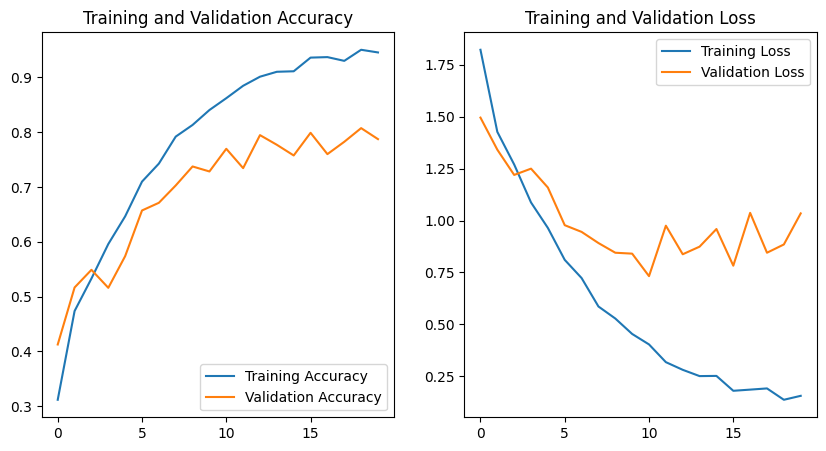

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit



### Write your findings here
- Training accuracy is in 90+ range where as validation is in 70 range.This difference between the training and validation accuraccy indiates Overfitting.
- Also, we can see from the graph that with each epoch the traning loss is decreasing where as the validation loss is increasing, which is an indication of overfitting.


### Data augmentation :

In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)

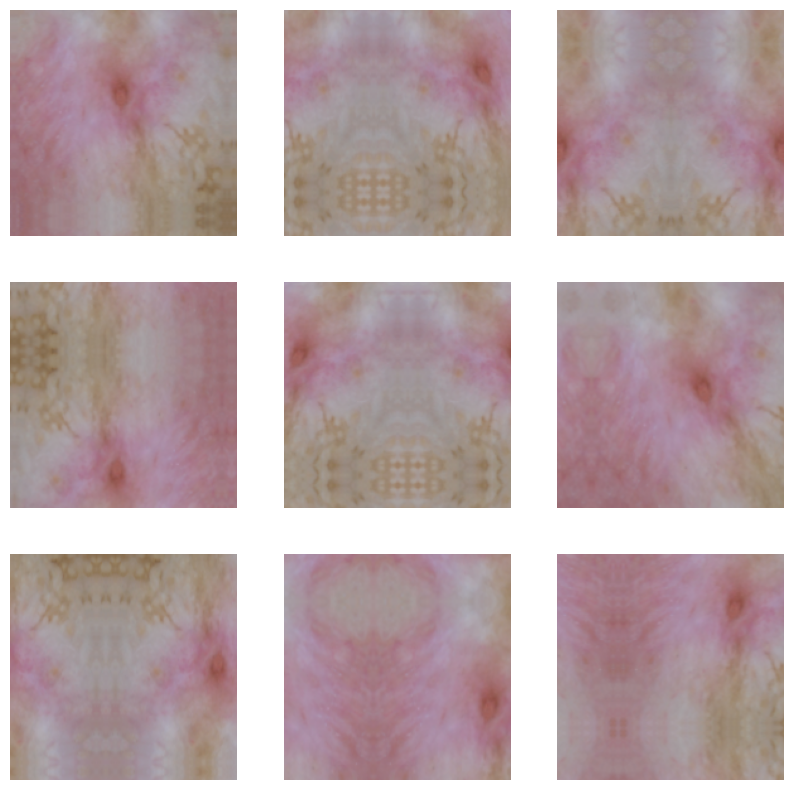

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [22]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [23]:
## Your code goes here, note: train your model for 20 epochs
## your training code
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
206/206 [==============================] - 35s 130ms/step - loss: 2.0781 - accuracy: 0.1909 - val_loss: 1.8563 - val_accuracy: 0.2888
Epoch 2/20
206/206 [==============================] - 23s 112ms/step - loss: 1.8228 - accuracy: 0.2741 - val_loss: 1.7842 - val_accuracy: 0.3106
Epoch 3/20
206/206 [==============================] - 23s 111ms/step - loss: 1.6541 - accuracy: 0.3474 - val_loss: 1.6745 - val_accuracy: 0.3568
Epoch 4/20
206/206 [==============================] - 23s 111ms/step - loss: 1.6063 - accuracy: 0.3826 - val_loss: 1.6227 - val_accuracy: 0.4036
Epoch 5/20
206/206 [==============================] - 23s 111ms/step - loss: 1.5332 - accuracy: 0.3966 - val_loss: 1.4801 - val_accuracy: 0.4395
Epoch 6/20
206/206 [==============================] - 23s 110ms/step - loss: 1.5345 - accuracy: 0.4022 - val_loss: 1.4846 - val_accuracy: 0.4176
Epoch 7/20
206/206 [==============================] - 23s 110ms/step - loss: 1.4889 - accuracy: 0.4214 - val_loss: 1.4903 - val_ac

### Visualizing the results

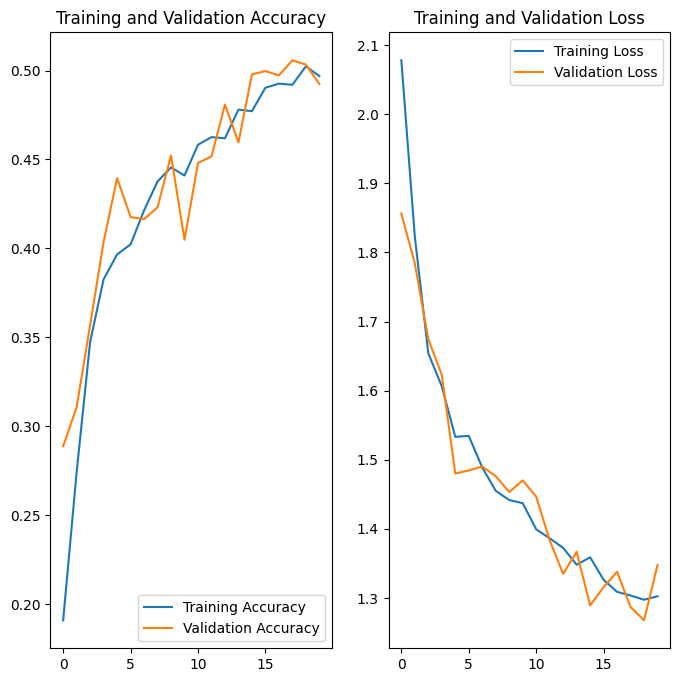

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
- From the above graph we can see that traning and validation accuracys are almost intersecting. So the agumentation has solved the problem of overfitting.
- But the overall accuracy/s are low for both training and valiation ds and overall losses have gone up for both.
- We can handle class imbalance and try to resolve this issue.

### Class distribution: Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2248

In [26]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Colab Notebooks/Train/...,melanoma
1,/content/gdrive/MyDrive/Colab Notebooks/Train/...,melanoma
2,/content/gdrive/MyDrive/Colab Notebooks/Train/...,melanoma
3,/content/gdrive/MyDrive/Colab Notebooks/Train/...,melanoma
4,/content/gdrive/MyDrive/Colab Notebooks/Train/...,melanoma
...,...,...
2243,/content/gdrive/MyDrive/Colab Notebooks/Train/...,pigmented benign keratosis
2244,/content/gdrive/MyDrive/Colab Notebooks/Train/...,pigmented benign keratosis
2245,/content/gdrive/MyDrive/Colab Notebooks/Train/...,pigmented benign keratosis
2246,/content/gdrive/MyDrive/Colab Notebooks/Train/...,pigmented benign keratosis


In [32]:
# images in each classes
class_diff=pd.DataFrame()
for i in range(len(class_names)):
  name= class_names[i]
  number = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)

class_diff

<ipython-input-32-799155ad79d5>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
<ipython-input-32-799155ad79d5>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
<ipython-input-32-799155ad79d5>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
<ipython-input-32-799155ad79d5>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
<ipy

,class,number
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,148


<function matplotlib.pyplot.show(close=None, block=None)>

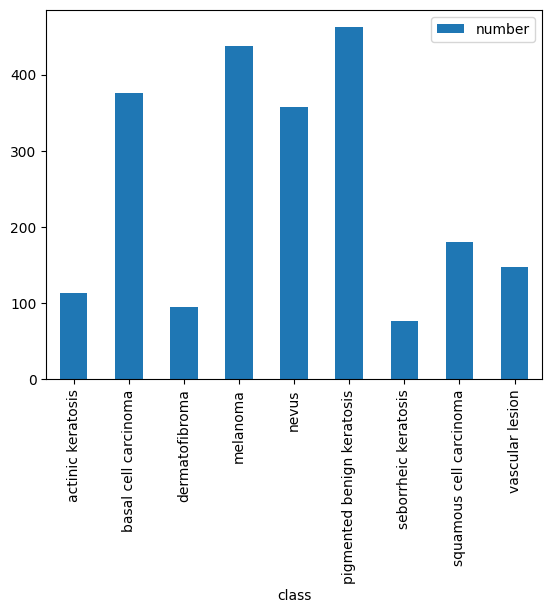

In [36]:
class_diff.plot.bar(x='class',y='number',rot=90)
plt.show

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
- seborrheic keratosis	77 has least number of samples

#### - Which classes dominate the data in terms proportionate number of samples?
- pigmented benign keratosis	462

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

### Handling class imbalances: Rectify class imbalances present in the training dataset with Augmentor library.

In [37]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [39]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab Notebooks/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    # p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
    p.sample(150) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DEB8C1F2B00>: 100%|██████████| 150/150 [00:05<00:00, 25.13 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DEB8C2C3E50>: 100%|██████████| 150/150 [00:07<00:00, 20.21 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DEB8394B070>: 100%|██████████| 150/150 [00:06<00:00, 24.23 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7DEB8C2C3E50>: 100%|██████████| 150/150 [00:28<00:00,  5.25 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DEB839EF310>: 100%|██████████| 150/150 [00:26<00:00,  5.73 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DEB8C2C3E50>: 100%|██████████| 150/150 [00:04<00:00, 32.85 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DEB8C19B1C0>: 100%|██████████| 150/150 [00:12<00:00, 11.97 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DEB839AB100>: 100%|██████████| 150/150 [00:05<00:00, 29.47 Samples/s]


Initialised with 148 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DEB8D7B9780>: 100%|██████████| 150/150 [00:06<00:00, 23.54 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [40]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

8657


### Lets see the distribution of augmented data after adding new images to the original training data.

In [41]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Colab Notebooks/Train/melanoma/output/melanoma_original_ISIC_0010000.jpg_b20b9d7f-4ca9-460b-8306-0e53ec8f4209.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Train/melanoma/output/melanoma_original_ISIC_0000432.jpg_97806594-edc5-451e-8cea-2551b062fc74.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Train/melanoma/output/melanoma_original_ISIC_0000522.jpg_d07a9ae5-9083-49ac-ba6f-53e08241d7b5.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Train/melanoma/output/melanoma_original_ISIC_0010007.jpg_53094e4c-50a6-47bd-84f4-ccd0d8d4c53c.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Train/melanoma/output/melanoma_original_ISIC_0009992.jpg_4e012b2c-4a9e-4551-a7c0-2a9d4aba41ab.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Train/melanoma/output/melanoma_original_ISIC_0010878.jpg_e58d9bc3-52dc-4284-9a63-c7180b254f9b.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Train/melanoma/output/melanoma_original_ISIC_0000279.jpg_c4e122b5-9ebc-4bb1-981e-819f077b9d5c.jpg',
 '/con

In [42]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [43]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [44]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-44-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [45]:
new_df['Label'].value_counts()

pigmented benign keratosis    1412
melanoma                      1388
basal cell carcinoma          1326
nevus                         1307
actinic keratosis             1192
squamous cell carcinoma       1131
vascular lesion               1077
dermatofibroma                1045
seborrheic keratosis          1027
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [46]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [47]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to
  image_size= (img_height, img_width),
  batch_size=batch_size)

Found 10905 files belonging to 9 classes.
Using 8724 files for training.


#### **Todo:** Create a validation dataset

In [48]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset =  'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10905 files belonging to 9 classes.
Using 2181 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

Model 1

In [49]:
## your code goes here
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [50]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [51]:
epochs = 50## Your code goes here, use 50 epochs.
 # your model fit code
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
273/273 [==============================] - 59s 69ms/step - loss: 1.7540 - accuracy: 0.3191 - val_loss: 1.4909 - val_accuracy: 0.4149
Epoch 2/50
273/273 [==============================] - 7s 25ms/step - loss: 1.3683 - accuracy: 0.4838 - val_loss: 1.2252 - val_accuracy: 0.5406
Epoch 3/50
273/273 [==============================] - 7s 26ms/step - loss: 1.1444 - accuracy: 0.5753 - val_loss: 1.0222 - val_accuracy: 0.6080
Epoch 4/50
273/273 [==============================] - 7s 26ms/step - loss: 0.9532 - accuracy: 0.6472 - val_loss: 1.1132 - val_accuracy: 0.6006
Epoch 5/50
273/273 [==============================] - 7s 26ms/step - loss: 0.7697 - accuracy: 0.7220 - val_loss: 0.7755 - val_accuracy: 0.7176
Epoch 6/50
273/273 [==============================] - 7s 26ms/step - loss: 0.6137 - accuracy: 0.7816 - val_loss: 0.8386 - val_accuracy: 0.7350
Epoch 7/50
273/273 [==============================] - 9s 32ms/step - loss: 0.5009 - accuracy: 0.8215 - val_loss: 0.6828 - val_accuracy: 0.778

#### **Todo:**  Visualize the model results

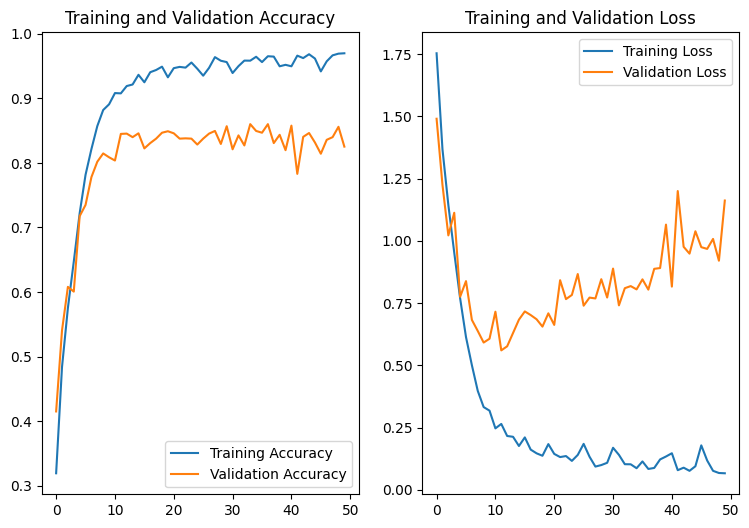

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(9, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Inference : Class rebalance has resulted in good Traning and Valdation accuracy. Training loss also seems good but Validation loss is increasing with each epoch so let's fix that.

Model 2

In [53]:
## your code goes here  - adding dropout after each Conv layer
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [54]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [55]:
epochs = 50
 # your model fit code
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
273/273 [==============================] - 9s 29ms/step - loss: 2.0470 - accuracy: 0.2157 - val_loss: 1.6556 - val_accuracy: 0.3563
Epoch 2/50
273/273 [==============================] - 8s 30ms/step - loss: 1.4719 - accuracy: 0.4414 - val_loss: 1.3479 - val_accuracy: 0.4979
Epoch 3/50
273/273 [==============================] - 8s 30ms/step - loss: 1.2514 - accuracy: 0.5291 - val_loss: 1.3368 - val_accuracy: 0.4750
Epoch 4/50
273/273 [==============================] - 8s 28ms/step - loss: 1.1127 - accuracy: 0.5881 - val_loss: 1.1348 - val_accuracy: 0.5663
Epoch 5/50
273/273 [==============================] - 8s 30ms/step - loss: 0.9350 - accuracy: 0.6586 - val_loss: 1.0492 - val_accuracy: 0.5961
Epoch 6/50
273/273 [==============================] - 9s 32ms/step - loss: 0.8026 - accuracy: 0.7114 - val_loss: 0.8900 - val_accuracy: 0.6795
Epoch 7/50
273/273 [==============================] - 9s 34ms/step - loss: 0.6761 - accuracy: 0.7587 - val_loss: 0.7233 - val_accuracy: 0.7474

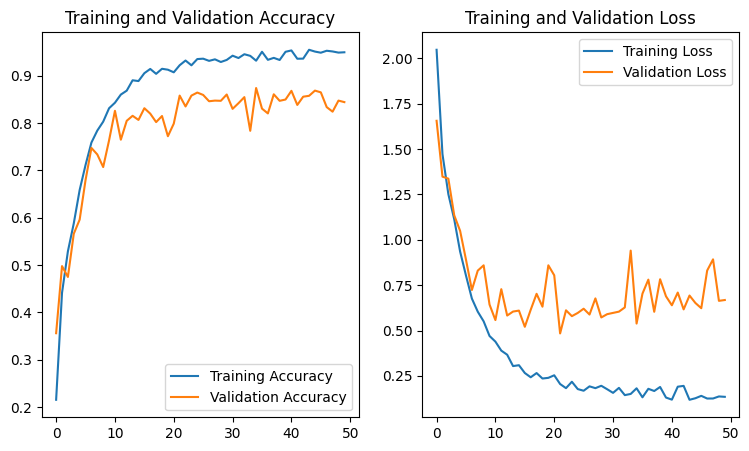

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Inference : Traning and Valdation accuracy are good. Validation loss has also come down considerably, but still fluctuating. Let's see if we can improve from here

Model 3

In [57]:
## your code goes here  - adding one more layer of convulution
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(126, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [58]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [59]:
epochs = 50
 # your model fit code
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
273/273 [==============================] - 10s 29ms/step - loss: 1.8696 - accuracy: 0.2655 - val_loss: 1.6295 - val_accuracy: 0.3641
Epoch 2/50
273/273 [==============================] - 7s 26ms/step - loss: 1.4684 - accuracy: 0.4359 - val_loss: 1.4627 - val_accuracy: 0.4149
Epoch 3/50
273/273 [==============================] - 7s 27ms/step - loss: 1.3002 - accuracy: 0.5037 - val_loss: 1.6986 - val_accuracy: 0.3581
Epoch 4/50
273/273 [==============================] - 7s 27ms/step - loss: 1.1463 - accuracy: 0.5692 - val_loss: 1.2286 - val_accuracy: 0.5209
Epoch 5/50
273/273 [==============================] - 7s 26ms/step - loss: 1.0143 - accuracy: 0.6198 - val_loss: 1.1556 - val_accuracy: 0.5608
Epoch 6/50
273/273 [==============================] - 7s 27ms/step - loss: 0.8515 - accuracy: 0.6856 - val_loss: 0.9599 - val_accuracy: 0.6410
Epoch 7/50
273/273 [==============================] - 7s 26ms/step - loss: 0.7142 - accuracy: 0.7375 - val_loss: 0.9634 - val_accuracy: 0.632

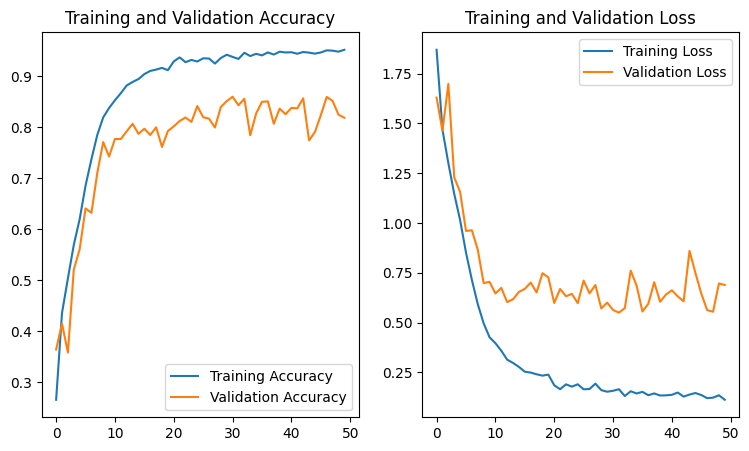

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Inference : Adding more convolution layers seems to increase the complexity of the model and we see not much change in validation loss while the accuracy dropped a bit.

Model 4

In [78]:
## your code goes here  - adding one more layer of convulution and dropout to dense layer
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  # layers.Dropout(0.2),
  layers.Dense(num_classes)
])

In [79]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [80]:
epochs = 50
 # your model fit code
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
273/273 [==============================] - 10s 30ms/step - loss: 2.1935 - accuracy: 0.1285 - val_loss: 2.1746 - val_accuracy: 0.1376
Epoch 2/50
273/273 [==============================] - 8s 30ms/step - loss: 1.9039 - accuracy: 0.2420 - val_loss: 1.6913 - val_accuracy: 0.3338
Epoch 3/50
273/273 [==============================] - 8s 29ms/step - loss: 1.5395 - accuracy: 0.3931 - val_loss: 1.3875 - val_accuracy: 0.4374
Epoch 4/50
273/273 [==============================] - 8s 29ms/step - loss: 1.3777 - accuracy: 0.4652 - val_loss: 1.2782 - val_accuracy: 0.4929
Epoch 5/50
273/273 [==============================] - 8s 30ms/step - loss: 1.2872 - accuracy: 0.4978 - val_loss: 1.2409 - val_accuracy: 0.5218
Epoch 6/50
273/273 [==============================] - 8s 30ms/step - loss: 1.1964 - accuracy: 0.5386 - val_loss: 1.0804 - val_accuracy: 0.5548
Epoch 7/50
273/273 [==============================] - 8s 30ms/step - loss: 1.0808 - accuracy: 0.5909 - val_loss: 1.0247 - val_accuracy: 0.613

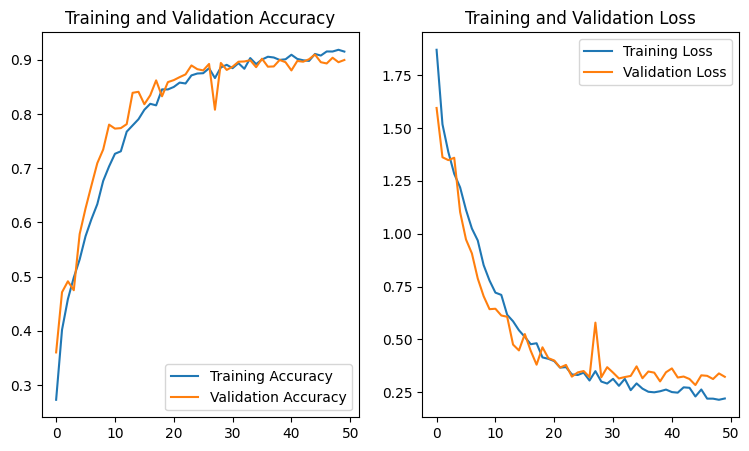

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

:#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

- The training and validation accuracy are almost overlapping.
- The training loss and validation loss are almost same. So we can say that this is a sign of good fit model.
- The class imbalance handling using Agumentation seems to have made an impact.
- Training accuracy 0.9356.
- The Validation accuracy is 0.90. The model is able to classify the images with 90% accuracy.

### Model Evaluation on Test Dataset

1/1 [==============================] - 0s 26ms/step
Actual Class: basal cell carcinoma
Predictive Class: basal cell carcinoma


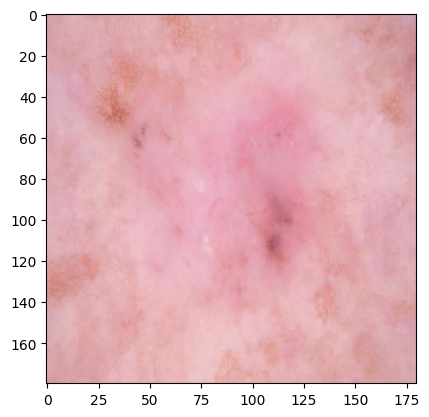

In [83]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class: {class_names[1]}" + '\n' + "Predictive Class: " + pred_class)

###Conclusion:
- Model was able to provide correct prediction on test dataset as seen above in Model Evaluation section

- Most of the problems in the data set were handled using different techniques like Agumentation and Class imbalance handling.

- And by using different filters with dropouts we can see that the best model has :
  - Training accuracy : 0.9356
  - Training loss: 0.1678
  - Validation accuarcy: 0.9088
  - Validation loss : 0.2926

